# AI in medicine - CADD exercise

**Tutor**: David Schaller  
**Institution**: Charité - Universitätsmedizin Berlin  
**Email**: david.schaller@charite.de  

This notebook is based on [TeachOpenCADD](https://github.com/volkamerlab/TeachOpenCADD/) and the scikit-learn [intro](https://github.com/volkamerlab/ai_in_medicine) from week 1.

## Aim

In this notebook, the experience gained in the first week will be applied to perform a virtual screening experiment for inhibitors of the epidermal growth factor receptor ([EGFR](https://en.wikipedia.org/wiki/Epidermal_growth_factor_receptor)) via machine learning. First, computer-friendly molecular representations will be introduced, which allow the training of machine learning models. Next, a support vector machine will be trained to classify molecules as active or inactive. The trained model will be used to predict the activity of a small molecule set. Finally, successsful participants can check their hits for potential activity against EGFR via online resources.

## Learning goals

- apply knowledge from first week
- represent molecules in a computer-friendly fashion
- perform a virtual screening experiment
- check online resources for potential activities

## Theory
The essential theory of machine learning algorithms was covered in the first week. The concept of virtual screening will be presented seperately via slides.

## References
- [epidermal growth factor receptor](https://en.wikipedia.org/wiki/Epidermal_growth_factor_receptor)
- [molecular fingerprints](http://infochim.u-strasbg.fr/CS3/program/material/Bajorath.pdf)
- [support vector machine](https://en.wikipedia.org/wiki/Support_vector_machine)
- [virtual screening](https://en.wikipedia.org/wiki/Virtual_screening)
- [TeachOpenCADD](https://github.com/volkamerlab/TeachOpenCADD/)
- [scikit-learn Intro from week 1](https://github.com/volkamerlab/ai_in_medicine)

## Python packages
- [scikit-learn](https://scikit-learn.org/stable/)
- [rdkit](https://www.rdkit.org/)
- [pandas](https://pandas.pydata.org/)
- [numpy](https://numpy.org/)
- [matplotlib](https://matplotlib.org/)

## Practical

When running this notebook on Azure, make sure the Python 3.6 kernel is selected. 

**Content**

1. Install RDKit  
2. Import modules  
3. Data preparation  
 3.1 Load data  
 3.2 Interpret molecules  
4. Classify data  
5. Split data  
6. Train a support vector classifier
7. Assess performance
8. Apply to unknown molecules

### 1. Install RDKit

RDKit is not installed in Azure notebooks. To install RDKit remove the `#` from the code line below and execute the cell. In my case the installation took about 1 h, so please execute the cell before this exercise starts. Closing the session will require to install RDKit again.

In [1]:
#!conda install -y -c conda-forge rdkit

### 2. Import modules

These modules are needed to perform all parts of this exercise. Feel free to add other modules, since there are multiple solutions to succeed.

In [2]:
#data handling
import numpy as np
import pandas as pd

# chemistry
from rdkit import Chem
from rdkit.Chem import MACCSkeys
from rdkit.Chem.Draw import IPythonConsole, rdMolDraw2D

# machine learning
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split

# plotting
import matplotlib.pyplot as plt

### 3. Data preparation

#### 3.1 Load data

We will use a subset of molecules retrieved from the [ChEMBL](https://www.ebi.ac.uk/chembl/) database, which contains ~5k molecules with reported activity against EGFR. The whole ChEMBL database currently contains ~16 million datapoints for ~2 million compounds.

***Insert code to load the data found in `data/egfr_chembl25.csv` into a pandas dataframe named 'df' and display the first few rows.***

In [3]:
# Read activity data for EGFR into a pandas dataframe named df
#################### <-- insert code below
df = pd.read_csv('data/egfr_chembl25.csv')
display(df.head())
df.info()
#################### <-- insert code above

,chembl_id,smiles,pIC50
0,CHEMBL207869,Clc1c(OCc2cc(F)ccc2)ccc(Nc2c(C#Cc3ncccn3)cncn2)c1,7.113509
1,CHEMBL3940060,ClCC(=O)OCCN1C(=O)Oc2c1cc1c(Nc3cc(Cl)c(F)cc3)n...,6.481486
2,CHEMBL3678951,FC(F)(F)c1cc(Nc2n(C(C)C)c3nc(Nc4ccc(N5CC[NH+](...,9.000000
3,CHEMBL504034,Clc1c(OCc2cc(F)ccc2)ccc(Nc2ncnc3c2sc(C#C[C@H]2...,7.397940
4,CHEMBL158797,S(Sc1n(C)c2c(c1C(=O)NCC(O)CO)cccc2)c1n(C)c2c(c...,4.366531


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4909 entries, 0 to 4908
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   chembl_id  4909 non-null   object 
 1   smiles     4909 non-null   object 
 2   pIC50      4909 non-null   float64
dtypes: float64(1), object(2)
memory usage: 115.2+ KB


The dataframe contains information about the ChEMBL ID, which can be used to query the ChEMBL database, a molecule in the form of a SMILES string and an activity value in the form of pIC50. The IC50 describes the molar concentration (mol/L) that will result in 50 percent of inhibition in-vitro. The pIC50 is the negative logarithm  óf IC50 often found in publications and databases.  
- pIC50 = -log10(IC50)  
- approved drugs often show an IC50 in the low nanomolar range
- IC50 = 5 nmol/L --> this concentration of drug is needed to get a 50 percent inhibiton in vitro
- pIC50 = -log10(5 / 10^9) = 8.3 --> devision by 10^9 needed to get from nmol/L to mol/L
- pIC50 = -log10(500 / 10^9) = 6.3
- --> The higher the pIC50, the more active the molecule

#### 3.2 Interpret molecules

Next, we will interpret the molecules that are stored as SMILES strings and transform them in a format that a machine learning algorithm can handle. The [RDKit](https://www.rdkit.org/) library is a free open-source framework that can be used to work with molecular data. In the following cells you will learn a few basic functionalities from RDKit and how you can store substructures of molecules in computer-friendly bit vectors, that can be later used to train your model.

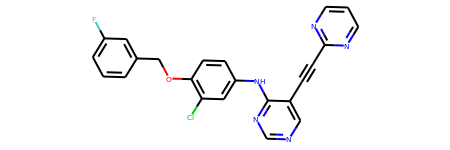

In [4]:
# pic the first SMILES stored in the dataframe and display the molecule with RDKit
mol = Chem.MolFromSmiles(df['smiles'][0])
mol

Molecules can be represented in form of [molecular fingerprints](http://infochim.u-strasbg.fr/CS3/program/material/Bajorath.pdf), which store the presence of substructures in a bit vector consisting of zeros and ones. Here we will use Molecular ACCess System (MACCS) keys, which are implemented in RDKit and record the presence of a predefined set of substructures.

In [5]:
maccs_keys = list(MACCSkeys.GenMACCSKeys(mol))
print(maccs_keys)
print('Zeros:', len(maccs_keys) - sum(maccs_keys))
print('Ones:', sum(maccs_keys))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0]
Zeros: 129
Ones: 38


Let's explore which substrucutres can be found in our sample molecule.

In [6]:
# Get indices of ones
maccs_key_series = pd.Series(maccs_keys)
maccs_key_series[maccs_key_series==1].index

Int64Index([ 17,  38,  42,  65,  77,  80,  87,  98, 103, 107, 109, 113, 120,
            121, 125, 126, 127, 133, 134, 135, 137, 142, 143, 144, 145, 150,
            151, 152, 153, 155, 156, 157, 158, 161, 162, 163, 164, 165],
           dtype='int64')

The underlying substructures are provided in RDKit via a dictionary and are represented as [SMARTS](https://www.daylight.com/dayhtml/doc/theory/theory.smarts.html), which is an extension of the SMILES language and especially useful for substructure searches. The SMARTS of bit 80 represents the substructure `[#7]~*~*~*~[#7]`.
- `#7` - nitrogen
- `~` - any bond
- `*` - any atom

We can also visualize substructures with the following lines. Just replace the `bit_index` with any of the indices found above.

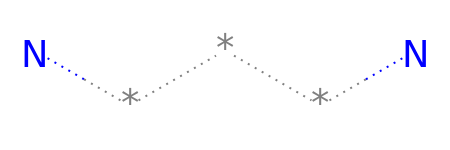

In [7]:
bit_index = 80
smarts = MACCSkeys.smartsPatts[bit_index][0]
Chem.MolFromSmarts(smarts)

Next, let's use the following function to add an rdkit representation and the maccs keys for each of the smiles in the data set.

In [8]:
def add_mols_and_maccs(df, smiles_column='smiles'):
    """
    Generate rdkit molecule objects and MACCSkeys and add them to the given dataframe.
    
    Parameters
    ----------
    df: pandas.DataFrame
        A data frame containing a column with SMILES.
    """
    df['mol'] = df[smiles_column].apply(Chem.MolFromSmiles)
    df['maccs'] = df['mol'].apply(MACCSkeys.GenMACCSKeys)
    return

In [9]:
# add columns for rdkit molecules and maccs keys
add_mols_and_maccs(df)
display(df.head())

,chembl_id,smiles,pIC50,mol,maccs
0,CHEMBL207869,Clc1c(OCc2cc(F)ccc2)ccc(Nc2c(C#Cc3ncccn3)cncn2)c1,7.113509,<rdkit.Chem.rdchem.Mol object at 0x7fb287e46a30>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,CHEMBL3940060,ClCC(=O)OCCN1C(=O)Oc2c1cc1c(Nc3cc(Cl)c(F)cc3)n...,6.481486,<rdkit.Chem.rdchem.Mol object at 0x7fb287e463f0>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,CHEMBL3678951,FC(F)(F)c1cc(Nc2n(C(C)C)c3nc(Nc4ccc(N5CC[NH+](...,9.000000,<rdkit.Chem.rdchem.Mol object at 0x7fb287e46b20>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,CHEMBL504034,Clc1c(OCc2cc(F)ccc2)ccc(Nc2ncnc3c2sc(C#C[C@H]2...,7.397940,<rdkit.Chem.rdchem.Mol object at 0x7fb287e46b70>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,CHEMBL158797,S(Sc1n(C)c2c(c1C(=O)NCC(O)CO)cccc2)c1n(C)c2c(c...,4.366531,<rdkit.Chem.rdchem.Mol object at 0x7fb287e46bc0>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."


### 4. Classify data

To train a machine learning model to classify molecules as active or inactive, we need to add an activity label to our data set.

***Insert code below that adds a column named 'active' to the dataframe that holds the value 1.0 if the pIC50 is higher than 6.3 and otherwise 0.0.***

In [10]:
# Mark every molecule as active with an pIC50 of > 6.3
####################
df['active'] = np.zeros(len(df))
df.loc[df[df['pIC50'] >= 6.3].index, 'active'] = 1.0
display(df.head())
####################

,chembl_id,smiles,pIC50,mol,maccs,active
0,CHEMBL207869,Clc1c(OCc2cc(F)ccc2)ccc(Nc2c(C#Cc3ncccn3)cncn2)c1,7.113509,<rdkit.Chem.rdchem.Mol object at 0x7fb287e46a30>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.0
1,CHEMBL3940060,ClCC(=O)OCCN1C(=O)Oc2c1cc1c(Nc3cc(Cl)c(F)cc3)n...,6.481486,<rdkit.Chem.rdchem.Mol object at 0x7fb287e463f0>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.0
2,CHEMBL3678951,FC(F)(F)c1cc(Nc2n(C(C)C)c3nc(Nc4ccc(N5CC[NH+](...,9.000000,<rdkit.Chem.rdchem.Mol object at 0x7fb287e46b20>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.0
3,CHEMBL504034,Clc1c(OCc2cc(F)ccc2)ccc(Nc2ncnc3c2sc(C#C[C@H]2...,7.397940,<rdkit.Chem.rdchem.Mol object at 0x7fb287e46b70>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.0
4,CHEMBL158797,S(Sc1n(C)c2c(c1C(=O)NCC(O)CO)cccc2)c1n(C)c2c(c...,4.366531,<rdkit.Chem.rdchem.Mol object at 0x7fb287e46bc0>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...",0.0


The following lines should find 2780 actives and 2129 actives.

In [11]:
print('Actives:', int(df['active'].sum()))
print('Inactives:', int(len(df)-df['active'].sum()))

Actives: 2780
Inactives: 2129


### 5. Split data

***Split the data into training and test set by using the [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) function.***

In [12]:
# specify features and label
x, y = df['maccs'].to_list(), df['active'].to_list()
# Split the features and labels into training and test sets
####################
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
####################

### 6. Train a support vector classifier

***Train a [support vector classifier](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html).***

In [13]:
# train model
####################
svc = SVC(probability=True)
svc.fit(x_train, y_train)
####################

/home/david/miniconda2/envs/cadd_medicine/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

### 7. Assess performance

- ***[predict](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC.predict) the activity of the test set***  
- ***assess the performance of your model by plotting a [ROC curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html) and calcuation of the [AUC](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html)***

In [14]:
# predict the activity of the test set
####################
y_test_pred = svc.predict(x_test)
####################

In [15]:
# calculate AUC
####################
svc_roc_auc = roc_auc_score(y_test, y_test_pred)
print('AUC:', svc_roc_auc)
####################

AUC: 0.7698901006535124


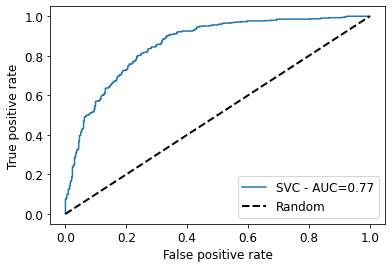

In [16]:
# plot the ROC curve
####################
fpr, tpr, thresholds = roc_curve(y_test, svc.predict_proba(x_test)[:,1])
plt.plot(fpr, tpr, label=f'SVC - AUC={round(svc_roc_auc,2)}')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.plot([0, 1], [0, 1], linestyle='--', label='Random', lw=2, color="black")  # Random curve
plt.xlabel('False positive rate', size=12)
plt.ylabel('True positive rate', size=12)
plt.tick_params(labelsize=12)
plt.legend(fontsize=12)
plt.show()
####################

### 8. Apply to unknown molecules

***Use your model and predict the activity of a set of unknown molecules located at*** `data/egfr_candidates.csv`***.***

In [17]:
# load data and assign maccs keys 
####################
df2 = pd.read_csv('data/egfr_candidates.csv')
add_mols_and_maccs(df2)
display(df2)
####################

,smiles,mol,maccs
0,COC1=C(OCCC[NH+]2CCOCC2)C=C2C(NC3=CC(Cl)=C(F)C...,<rdkit.Chem.rdchem.Mol object at 0x7fb287ac2ad0>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,COCCOC1=CC2=C(C=C1OCCOC)C(NC1=CC(=CC=C1)C#C)=N...,<rdkit.Chem.rdchem.Mol object at 0x7fb287ac27b0>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,C[NH+](C)C\C=C\C(=O)NC1=C(OC2CCOC2)C=C2N=CN=C(...,<rdkit.Chem.rdchem.Mol object at 0x7fb287ac2d00>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,CS(=O)(=O)CCNCC1=CC=C(O1)C1=CC2=C(C=C1)N=CN=C2...,<rdkit.Chem.rdchem.Mol object at 0x7fb287abeee0>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,CCOC1=C(NC(=O)C=CC[NH+](C)C)C=C2C(NC3=CC(Cl)=C...,<rdkit.Chem.rdchem.Mol object at 0x7fb287abe3a0>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
5,COC1=C(NC2=NC=C(Cl)C(NC3=CC=CC=C3P(C)(C)=O)=N2...,<rdkit.Chem.rdchem.Mol object at 0x7fb287abe260>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
6,C#CC1=CC(=CC=C1)NC2=NC=NC3=CC4=C(C=C32)OCCOCCO...,<rdkit.Chem.rdchem.Mol object at 0x7fb287abef30>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
7,COC1=C(NC2=NC=CC(=N2)C2=CN(C)C3=CC=CC=C23)C=C(...,<rdkit.Chem.rdchem.Mol object at 0x7fb287abee40>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [18]:
# predict the activity
####################
y_pred_svc = svc.predict(df2['maccs'].tolist())
display(y_pred_svc)
####################

array([1., 1., 1., 1., 0., 1., 1., 1.])

***Visit [PubChem](https://pubchem.ncbi.nlm.nih.gov/), an only resource for chemical information, and query the database with a smiles of a predicted active and predicted inactive. What can you find out about the molecules?***